In [1]:
%load_ext cython

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np

In [3]:
from tqdm import tqdm

In [109]:
%%cython -+ 
cimport cython
import numpy as np
cimport numpy as np

from libc.math cimport exp, tanh
from mc_lib.rndm cimport RndmWrapper
from mc_lib.lattices import tabulate_neighbors
from mc_lib.observable cimport RealObservable

cdef RndmWrapper rndm = RndmWrapper((1234, 0))
    
cdef void init_spins(long[::1] spins): 
    
    for j in range(spins.shape[0]):
        spins[j] = 1 if rndm.uniform() > 0.5 else -1
        
        
        
@cython.boundscheck(False)
@cython.wraparound(False)
cdef double energy(long[::1] spins, 
                   long[:, ::1] neighbors,
                  const double[:,::1] Js):

    cdef:
        double ene = 0.0
        Py_ssize_t site, site1, num_neighb

    for site in range(spins.shape[0]):
        num_neighb = neighbors[site, 0]
        for j in range(1, num_neighb+1):
            site1 = neighbors[site, j]
            ene += -1 * Js[site, site1] * spins[site] * spins[site1] 
    
    return ene / 2.0



@cython.boundscheck(False)
@cython.wraparound(False)
cdef void flip_spin(long[::1] spins, 
                    const long[:, ::1] neighbors,
                    double beta,
                    const double[:,::1] Js): 
    cdef:
        Py_ssize_t site = int(spins.shape[0] * rndm.uniform())
        Py_ssize_t site1

    cdef long num_neighb = neighbors[site, 0]
    cdef double summ = 0.
    for j in range(1, num_neighb + 1):
        site1 = neighbors[site, j]
        summ += spins[site1] * spins[site] * Js[site,site1]
   
    cdef double ratio = exp(-2.0 * beta * summ )
    
    if rndm.uniform() > ratio:
        return

    spins[site] = -spins[site]
    
    
cdef void get_J( double[:,::1] Js, double J, double Jd, int L1, int L2 , int L3 = 1):
  
    if L3 == 1:
        for i in range(L1*L2):
            Js[i, ((i // L2 + 1) % L1 * L2 )  + (i + 1) % L2 ] = Jd
            Js[i, ((i // L2  - 1) % L1 * L2 )  + (i - 1) % L2 ] = Jd
            Js[i, (i // L2) * L2 + (i + 1) % L2] = J 
            Js[i, (i + L2) % (L1*L2)] = J
            Js[i, (i // L2) * L2 + (i - 1) % L2] = J
            Js[i, (i - L2) % (L1*L2)] = J
        return
    
    else:
        return
        

def simulate(Py_ssize_t L,
             double T, double J, double Jd,
             Py_ssize_t num_sweeps, Py_ssize_t num_therm = int(1e4)):

    cdef:
        long[:, ::1] neighbors = tabulate_neighbors(L, kind='triang') 
        double beta = 1./T

    cdef:
        
        #int num_therm = int(1e4)
        int num_prnt = 10000
        int steps_per_sweep = 100
        int step = 0, sweep = 0
        int i
        double Z = 0., magn = 0., av_magn_2=0., av_magn_4 = 0., binder = 0.

    cdef long[::1] spins =  np.empty( L*L, dtype=int) 
    init_spins(spins)
    
    cdef double[:,::1] Js = np.zeros((L*L, L*L)) 
    get_J(Js, J, Jd, L, L)

    for sweep in range(num_therm):
        for i in range(steps_per_sweep):
            step += 1
            flip_spin(spins, neighbors, beta, Js)

    for sweep in range(num_sweeps):
        for i in range(steps_per_sweep):
            step += 1
            flip_spin(spins, neighbors, beta, Js)
            
        Z += 1
        magn = 0.
        for i in range(L*L):
            magn += spins[i]
        av_magn_2 += magn**2
        av_magn_4 += magn**4
        
    binder = 1 - (av_magn_4 / Z) / (3 * (av_magn_2 / Z)**2)
     
    return binder 
  

Найдем область пересечения графиков Binder cumulant для различных размеров решетки.
При Jd = 0 она должна включать окрестность Tс =  2.269.

In [83]:
Temps = np.linspace(2.2, 2.3, 20)

In [100]:
binder_10 = []
binder_20 = []
binder_40 = []

for t in tqdm(Temps):
    binder_10.append(simulate(10,t,1,0,int(2e5),int(1e5)))
    binder_20.append(simulate(20,t,1,0,int(2e6),int(1e5)))
    binder_40.append(simulate(40,t,1,0,int(2e6),int(1e5)))

100%|██████████| 20/20 [11:33<00:00, 34.65s/it]


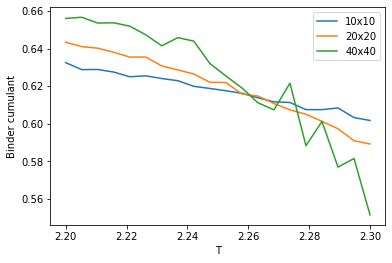

In [101]:
plt.plot(Temps, binder_10, label = '10x10')
plt.plot(Temps, binder_20, label = '20x20')
plt.plot(Temps, binder_40, label = '40x40')
plt.legend()

plt.xlabel("T")
plt.ylabel("Binder cumulant")
plt.show()

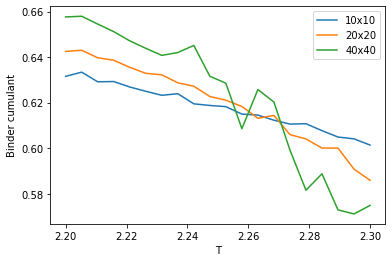

In [99]:
# это одно и то же, я три раза посчитала
plt.plot(Temps, binder_10, label = '10x10')
plt.plot(Temps, binder_20, label = '20x20')
plt.plot(Temps, binder_40, label = '40x40')
plt.legend()

plt.xlabel("T")
plt.ylabel("Binder cumulant")
plt.show()

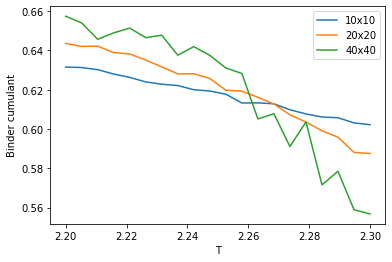

In [97]:
# и это
plt.plot(Temps, binder_10, label = '10x10')
plt.plot(Temps, binder_20, label = '20x20')
plt.plot(Temps, binder_40, label = '40x40')
plt.legend()

plt.xlabel("T")
plt.ylabel("Binder cumulant")
plt.show()

По какой то причине с ростом размера решетки растет разброс этой величины, приходится усреднять большее число измерений.
Я строила графики средней энергии для различных размеров решетки и все они одинаково нормальные, умеренно гладкие. Поэтому мне кажется, что большее количество итераций для термализации не нужно и некое равновесие достигается. Наверное, для этой величины нормально иметь такой большой диапазон значений?

Зеленая сильно прыгает, чтобы ее сгладить потребуется больше времени. Пока получается, что 2.25 < Tc < 2.28, около 2.26 в общем. Возможно, этого достаточно. 

Сделаю то же при других значениях Jd:

При Jd = -0.1 Tc = 2.105 из уравнения. 

In [102]:
Temps = np.linspace(2.06, 2.14, 20)

In [103]:
binder_10 = []
binder_20 = []
binder_40 = []

for t in tqdm(Temps):
    binder_10.append(simulate(10,t,1,-0.1,int(2e5),int(1e5)))
    binder_20.append(simulate(20,t,1,-0.1,int(2e6),int(1e5)))
    binder_40.append(simulate(40,t,1,-0.1,int(2e6),int(1e5)))

100%|██████████| 20/20 [12:16<00:00, 36.85s/it]


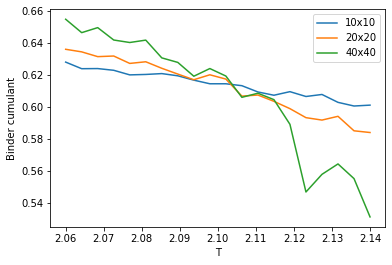

In [104]:
plt.plot(Temps, binder_10, label = '10x10')
plt.plot(Temps, binder_20, label = '20x20')
plt.plot(Temps, binder_40, label = '40x40')
plt.legend()

plt.xlabel("T")
plt.ylabel("Binder cumulant")
plt.show()

Здесь тоже очень похоже получается.

При Jd = -0.5 Tc = 1.342 

In [105]:
Temps = np.linspace(1.30, 1.38, 20)

In [107]:
binder_10 = []
binder_20 = []
binder_40 = []

for t in tqdm(Temps):
    binder_10.append(simulate(10,t,1,-0.5,int(2e5),int(1e5)))
    binder_20.append(simulate(20,t,1,-0.5,int(2e6),int(1e5)))
    binder_40.append(simulate(40,t,1,-0.5,int(2e6),int(1e5)))

100%|██████████| 20/20 [11:19<00:00, 33.97s/it]


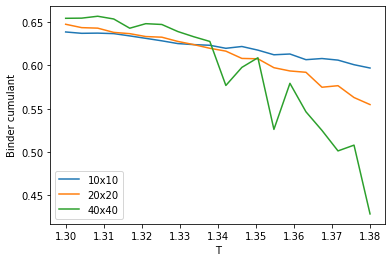

In [108]:
plt.plot(Temps, binder_10, label = '10x10')
plt.plot(Temps, binder_20, label = '20x20')
plt.plot(Temps, binder_40, label = '40x40')
plt.legend()

plt.xlabel("T")
plt.ylabel("Binder cumulant")
plt.show()

В целом близко к теоретическому значению получается